<a href="https://colab.research.google.com/github/RajanMehta/Deep-Learning-Supervised/blob/master/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rajan Mehta

ID: 2718747

We are (again) using two awesome datasets for this assignment - US county-level census
estimates from 2015 (American Community Survey) and summarized/aggregated data for the
VIIRS satellite which takes a picture of the Earth every night at ~1:30 AM local time. For each
county, I fit a function to calculate the percentiles of nighttime light (NTL) brightness per county.
While the first homework had a subset of all of the data (13 columns of data), I am now giving
you >400 columns of data corresponding to different features I’ve engineered.
● Background on county-level estimate data - your target variable is POPESTIMATE2015
(county-level population estimate from 2015)  https://www.census.gov/programs-surveys/acs/

● Background on monthly VIIRS NTL data from 2013 to 2017 - you should use all columns
starting with “DW” like “DW1, DW2…. DW468” etc. https://ncc.nesdis.noaa.gov/VIIRS/

● I’ve also given you land and water area (sq km) per county. Use these columns “ALAND”
and “AWATER” in your model.

But remember, this is only background info - all you should care about is turning those input
variables (brightness of NTL and land/water area) into the output variable (county-level
population estimates).

### Importing all necessary libraries

In [0]:
import warnings
warnings.filterwarnings('ignore')

# Load pandas
import pandas as pd

# Load numpy
import numpy as np

# Load scikit's libraries
from sklearn.ensemble import RandomForestRegressor

# Load keras libraries
from keras import models
from keras import layers

Using TensorFlow backend.


### Uploading the dataset

In [0]:
url = "https://drive.google.com/uc?export=download&id=1DtMyYnl0eyg2iidn-YkFxx2rGuwHnDfy"

df = pd.read_csv(url, encoding='ISO-8859-1')
df.head(3)

,Unnamed: 0,STATEFP,COUNTYFP,GEOID,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,...,DW465,DW466,DW467,DW468,SUMLEV,REGION,DIVISION,STNAME,CTYNAME,medianPopulation
0,1,1,1,1001,161526,0500000US01001,Autauga,6,1.539615e+09,25744269,...,3.880,8.607000,17.297400,158.570007,50,3,6,Alabama,Autauga,54864
1,2,1,101,1101,161577,0500000US01101,Montgomery,6,2.033764e+09,37997545,...,29.546,43.797999,59.381201,163.380005,50,3,6,Alabama,Montgomery,227002
2,3,1,103,1103,161578,0500000US01103,Morgan,6,1.500602e+09,50931876,...,14.610,26.245000,45.651401,1154.489990,50,3,6,Alabama,Morgan,119199


### Preprocessing Data

In [0]:
data = df.loc[:, 'ALAND':'DW468']
data['medianPopulation'] = df['medianPopulation']

data_scaled = (data-data.min())/(data.max()-data.min())    #MinMax Scaling

In [0]:
np.random.seed(123)
mask = np.random.rand(len(df)) < 0.8     # random numbers each between 0 to 1. Condition creates a boolean array which can be used to filter train-test sets

train = data_scaled[mask]
test = data_scaled[~mask]

In [0]:
train.head(3)

,ALAND,AWATER,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,...,DW460,DW461,DW462,DW463,DW464,DW465,DW466,DW467,DW468,medianPopulation
0,0.004070,0.000727,0.128059,0.044505,0.036473,0.030583,0.021842,0.012469,0.008944,0.008701,...,0.012085,0.009416,0.008332,0.008234,0.010647,0.017051,0.030410,0.046613,0.008133,0.005411
1,0.005380,0.001074,0.123980,0.045123,0.037561,0.032039,0.022953,0.013645,0.011768,0.019220,...,0.012403,0.010292,0.011694,0.021226,0.085511,0.129839,0.154746,0.160021,0.008379,0.022415
2,0.003966,0.001439,0.132953,0.050068,0.041372,0.035437,0.025544,0.015763,0.012239,0.013291,...,0.016220,0.013576,0.012571,0.013815,0.028255,0.064203,0.092728,0.123021,0.059212,0.011766


### Neural Network Definition

In [0]:
def build_neural():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(940, activation='relu',
                           input_shape=(470,)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(470, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(235, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(117, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(58, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse','mae'])
    return model

### Crossvalidation Scores

In [0]:
import random
random.seed(123)

def data_split(dataset, folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / folds)
	for i in range(folds):
		fold = list()
		while len(fold) < fold_size:
			index = random.randrange(len(dataset_copy))  #rows are randomly picked to be put in each fold
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

def poprow(my_array,pr):
    """ row popping in numpy arrays
    Input: my_array - NumPy array, pr: row index to pop out
    Output: [new_array,popped_row] """
    i = pr
    pop = my_array[i]
    new_array = np.vstack((my_array[:i],my_array[i+1:]))
    return [new_array,pop]

def absolute_percentage_error(y_true, y_pred):           #calculates APE
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return (np.abs((y_true - y_pred) / y_true)) * 100

def absolute_error(y_true, y_pred):                      #calculates AE
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.abs((y_true - y_pred))

def cross_validation(splits, clf):         #Input: splitted data from data_split() function and classifier. Output: array of mean of MAPE and MAE
  MAPE=[]
  MAE = []
  mse_histories = []
  mae_histories = []
  val_mse_histories = []
  val_mae_histories = []
  
  splits = np.array(splits)
  for i in range(10):
    [subtrain, subtest] = poprow( splits, i )

    subtrain = subtrain.tolist()
    subtrain_final = [e for sl in subtrain for e in sl]

    subtrain_df = pd.DataFrame(subtrain_final, columns=train.columns)
    subtest_df = pd.DataFrame(subtest, columns=train.columns)

    y_train = subtrain_df['medianPopulation'].values
    X_train = subtrain_df.drop(['medianPopulation'], axis=1)

    y_test = subtest_df['medianPopulation'].values
    X_test = subtest_df.drop(['medianPopulation'], axis=1)
    
    if(clf=='rf'): 
      clf = RandomForestRegressor()
      clf.fit(X_train, y_train)
      y_pred = clf.predict(X_test)
      val_mse_histories = []
      val_mae_histories = []
      mse_histories = []
      mae_histories = []
    else:
      num_epochs = 200
      clf = build_neural()
      # Train the model (in silent mode, verbose=0)
      history = clf.fit(X_train, y_train,
                          validation_data=(X_test, y_test),
                        epochs=num_epochs, batch_size=100,verbose=0)
      y_pred = clf.predict(X_test)
      
      val_mse_history = history.history['val_mean_squared_error']
      val_mae_history = history.history['val_mean_absolute_error']
      mse_history = history.history['mean_squared_error']
      mae_history = history.history['mean_absolute_error']
      
      val_mse_histories.append(val_mse_history)
      val_mae_histories.append(val_mae_history)
      mse_histories.append(mse_history)
      mae_histories.append(mae_history)

    MAPE.append( np.mean(absolute_percentage_error(y_test, y_pred)) )
    MAE.append( np.mean(absolute_error(y_test, y_pred)) )

  return MAPE, MAE, val_mse_histories, val_mae_histories, mse_histories, mae_histories

In [0]:
splits = data_split(train.values, folds=10)
NN_MAPE, NN_MAE, NN_VAL_MSE_hist, NN_VAL_MAE_hist, NN_TR_MSE_hist, NN_TR_MAE_hist = cross_validation(splits, 'nn')
RF_MAPE, RF_MAE, RF_VAL_MSE_hist, RF_VAL_MAE_hist, RF_TR_MSE_hist, RF_TR_MAE_hist = cross_validation(splits, 'rf')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


### Plotting and Summarizing the scores

In [0]:
import matplotlib.pyplot as plt

def smooth_curve(points, factor=0.5):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

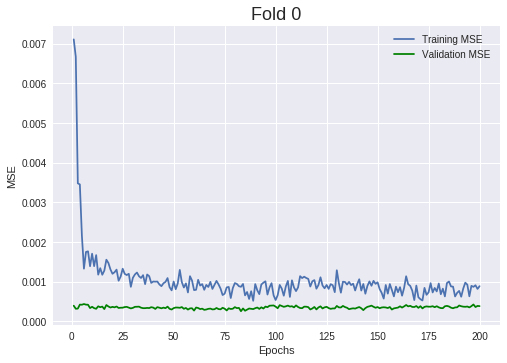

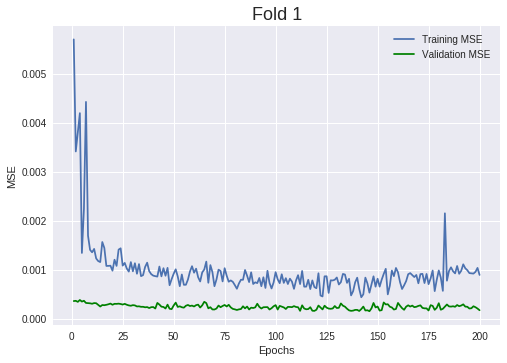

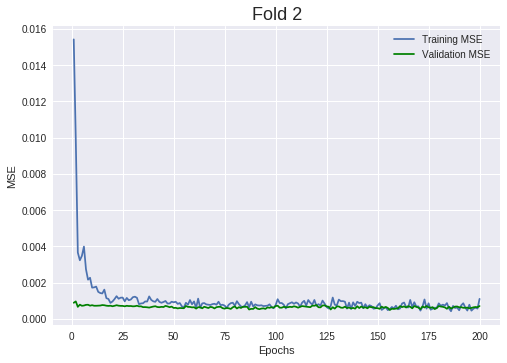

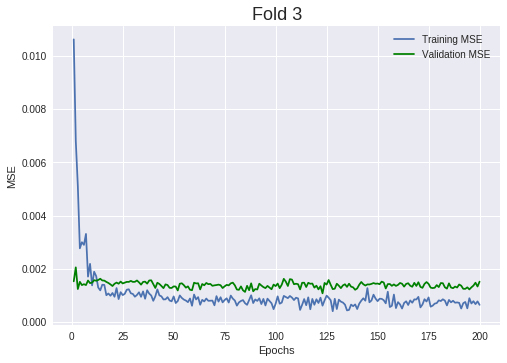

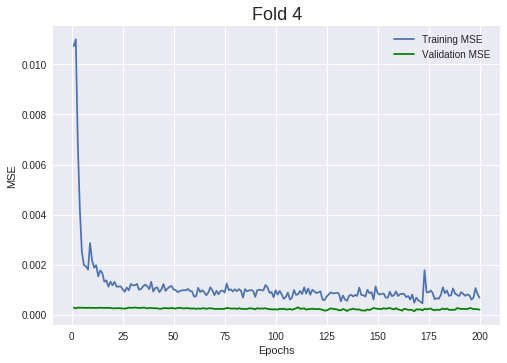

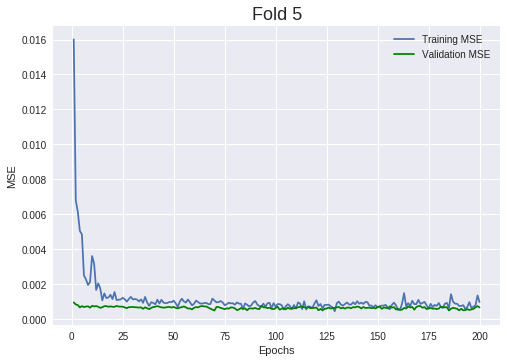

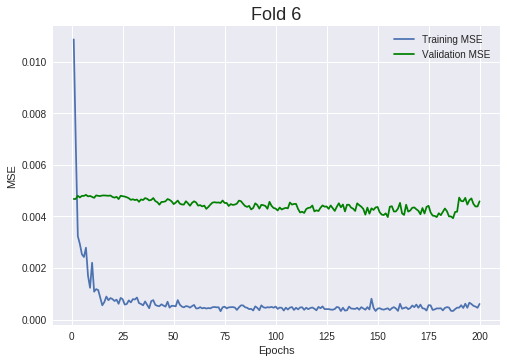

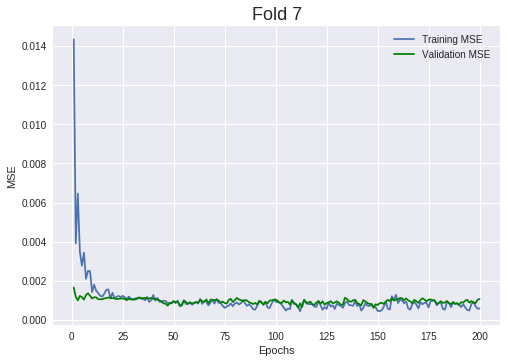

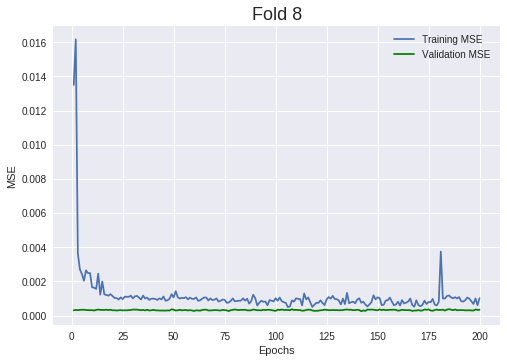

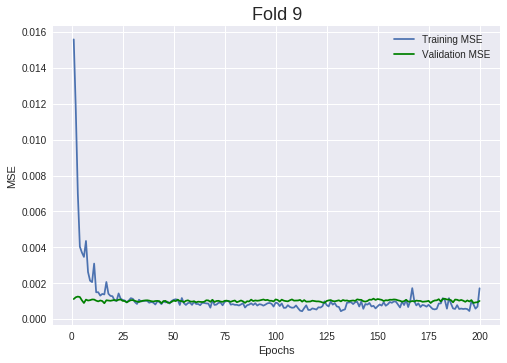

In [0]:
for i in range(10):
  
  plt.plot(range(1,len(NN_TR_MSE_hist[i])+1), NN_TR_MSE_hist[i], label='Training MSE ')
  plt.plot(range(1,len(NN_VAL_MSE_hist[i])+1), NN_VAL_MSE_hist[i], 'g', label='Validation MSE')
  plt.title('Fold {}'.format(i), fontsize=18)
  plt.xlabel('Epochs')
  plt.ylabel('MSE')
  plt.legend()

  plt.show()

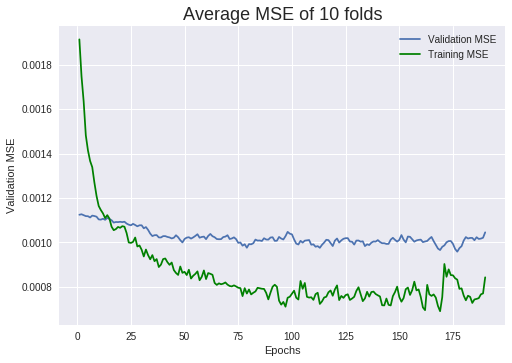

In [0]:
num_epochs = 200

avg_val_mse_history = [
    np.mean([x[i] for x in NN_VAL_MSE_hist]) for i in range(num_epochs)]

avg_tr_mse_history = [
    np.mean([x[i] for x in NN_TR_MSE_hist]) for i in range(num_epochs)]

smooth_val_mse_history = smooth_curve(avg_val_mse_history[10:])
smooth_tr_mse_history = smooth_curve(avg_tr_mse_history[10:])

plt.plot(range(1, len(smooth_val_mse_history) + 1), smooth_val_mse_history, label='Validation MSE')
plt.plot(range(1, len(smooth_tr_mse_history) + 1), smooth_tr_mse_history,'g', label='Training MSE')
plt.title('Average MSE of 10 folds', fontsize=18)
plt.xlabel('Epochs')
plt.ylabel('Validation MSE')
plt.legend()
plt.show()

In [0]:
best_mae_values = pd.DataFrame({
    'Test Epochs': [l.index(min(l)) for l in NN_VAL_MAE_hist],
    'Min MAE Value': [min(l) for l in NN_VAL_MAE_hist]
})

best_mae_values.index += 1
best_mae_values.index.name = 'Fold'
best_mae_values

,Min MAE Value,Test Epochs
Fold,,
1,0.005436,84
2,0.004815,140
3,0.008617,185
4,0.008268,62
5,0.005852,164
6,0.007248,194
7,0.009638,161
8,0.009518,110
9,0.005993,193


In [0]:
validation_scores = pd.DataFrame(
    {'RF_MAPE': RF_MAPE,
     'RF_MAE': RF_MAE,
     'NN_MAPE': NN_MAPE,
     'NN_MAE': NN_MAE
    })

validation_scores.loc['Mean'] = validation_scores[~validation_scores.isin([np.nan, np.inf, -np.inf]).any(1)].mean()
validation_scores.loc['Std Dev'] = validation_scores[~validation_scores.isin([np.nan, np.inf, -np.inf]).any(1)].std()

validation_scores      #cross-validation scores of each fold
                       #Mean of cross-validation scores of all folds for all algorithms

,NN_MAE,NN_MAPE,RF_MAE,RF_MAPE
0,0.007945,471.415134,0.003225,93.979367
1,0.010435,817.219645,0.010332,849.578722
2,0.011300,434.935302,0.012699,710.242372
3,0.012047,458.903205,0.011817,332.073109
4,0.009127,1727.331796,0.007441,866.609251
5,0.010576,658.945122,0.010595,673.112723
6,0.013740,475.863348,0.013036,264.546464
7,0.012830,411.233999,0.014144,705.759949
8,0.008577,947.424766,0.008330,892.653060
9,0.009721,inf,0.008697,inf


### Prediction on test sample with best model

In [0]:
y_train = train['medianPopulation'].values
X_train = train.drop(['medianPopulation'], axis=1)

y_test = test['medianPopulation'].values
X_test = test.drop(['medianPopulation'], axis=1)

model = models.Sequential()
model.add(layers.Dense(940, activation='relu',
                       input_shape=(470,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(470, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(235, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(117, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(58, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

model.fit(X_train, y_train,epochs=50, batch_size=100,verbose=0)    # based on the chart, optimal number of epochs = 50

In [0]:
y_pred = model.predict(test.drop(['medianPopulation'], axis=1))

In [0]:
test['prediction'] = y_pred
test['STNAME'] = df[~mask]['STNAME']
test['CTYNAME'] = df[~mask]['CTYNAME']

test['APE'] = absolute_percentage_error(test['medianPopulation'].reshape(641,1), y_pred)
test['AE'] = absolute_error(test['medianPopulation'].reshape(641,1), y_pred)

test.head(3)      # added APE and AE columns to the test dataframe

,ALAND,AWATER,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,...,DW465,DW466,DW467,DW468,medianPopulation,prediction,STNAME,CTYNAME,APE,AE
6,0.004264,0.000171,0.118271,0.041414,0.033751,0.028155,0.019251,0.010116,0.005335,0.003538,...,0.004175,0.005724,0.008864,0.002219,0.001023,0.004343,Alabama,Bullock,324.647038,0.003320
21,0.004084,0.000482,0.124796,0.043269,0.035384,0.029612,0.020732,0.011293,0.006590,0.005450,...,0.014653,0.026605,0.039626,0.003251,0.003345,0.004394,Alabama,Chambers,31.369579,0.001049
37,0.006709,0.001106,0.118271,0.038942,0.031573,0.026214,0.017770,0.008940,0.004864,0.004207,...,0.009184,0.016231,0.036784,0.005577,0.004035,0.004366,Alabama,Dallas,8.192766,0.000331


In [0]:
# creating new dataframe consisting of data of CA, TX and FL
STFilter = test[ (test['STNAME'] == 'California') | (test['STNAME'] == 'Texas') | (test['STNAME'] == 'Florida')]

STFilter.reset_index(inplace=True)    #so that the index is in order 0,1,2,3...

In [0]:
# list of the 50 worst predicted counties in the US as per the value of APE

test.sort_values(by='APE' ,axis=0, ascending=False).head(50)[ ['APE','STNAME','CTYNAME'] ]

,APE,STNAME,CTYNAME
2436,16545.039223,Texas,McMullen
661,7967.808431,Alaska,Yakutat City and Borough
1380,7253.995804,Montana,Treasure
1522,6912.115911,Nebraska,Hooker
3122,6606.047360,Colorado,Mineral
2408,6513.958031,Texas,Kent
1399,5881.267264,Montana,Golden Valley
1543,5827.106415,Nevada,Esmeralda
2508,5558.617140,Texas,Terrell
315,5492.464601,Idaho,Clark


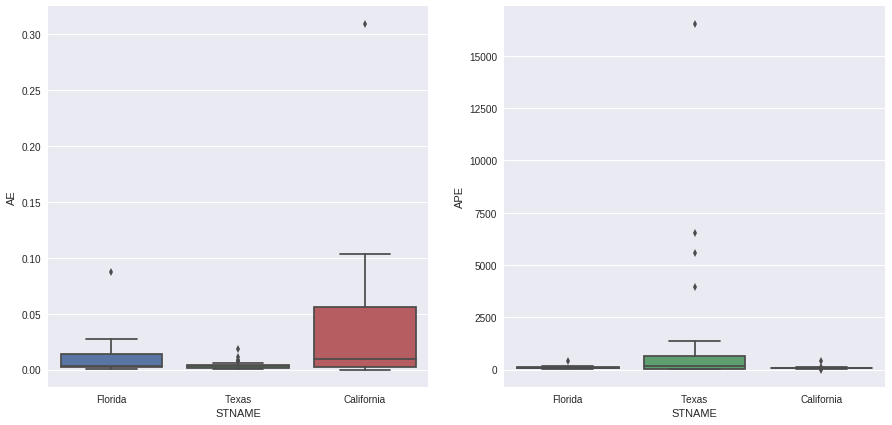

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

sns.boxplot(x="STNAME", y="AE", data=STFilter, ax=ax1)
sns.boxplot(x="STNAME", y="APE", data=STFilter, ax=ax2)

The graphs are not proper because of few extreme outliers. So, I will remove those outliers

In [0]:
STFilter[ (STFilter['AE'] > 0.2) & (STFilter['STNAME'] == 'California') ]    #outlier for California

,index,ALAND,AWATER,DW1,DW2,DW3,DW4,DW5,DW6,DW7,...,DW465,DW466,DW467,DW468,medianPopulation,prediction,STNAME,CTYNAME,APE,AE
69,3055,0.028893,0.023242,0.113377,0.034615,0.027763,0.02233,0.014808,0.007058,0.004237,...,0.094367,0.118156,0.134322,0.01785,0.324993,0.015649,California,San Diego,95.184874,0.309344


In [0]:
STFilter[ (STFilter['APE'] > 10000) & (STFilter['STNAME'] == 'Texas') ]      #outlier for Texas

,index,ALAND,AWATER,DW1,DW2,DW3,DW4,DW5,DW6,DW7,...,DW465,DW466,DW467,DW468,medianPopulation,prediction,STNAME,CTYNAME,APE,AE
32,2436,0.007816,0.001243,0.106036,0.036469,0.02994,0.026699,0.01851,0.009881,0.008473,...,0.072357,0.151512,0.278343,0.072606,0.00007,0.011625,Texas,McMullen,16545.039223,0.011555


In [0]:
STFilter.drop(STFilter.index[[69, 32]], inplace=True)    #removing these two outliers

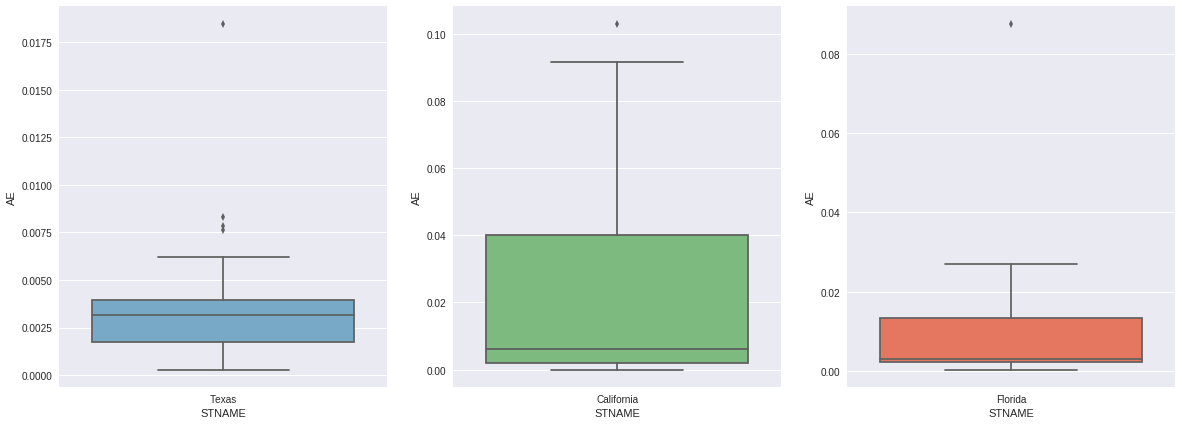

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,7))

sns.boxplot(x='STNAME', y="AE", data=STFilter[ STFilter['STNAME'] == 'Texas' ], ax=ax1, palette="Blues")
sns.boxplot(x='STNAME', y="AE", data=STFilter[ STFilter['STNAME'] == 'California' ], ax=ax2, palette="Greens")
sns.boxplot(x='STNAME', y="AE", data=STFilter[ STFilter['STNAME'] == 'Florida' ], ax=ax3, palette="Reds")

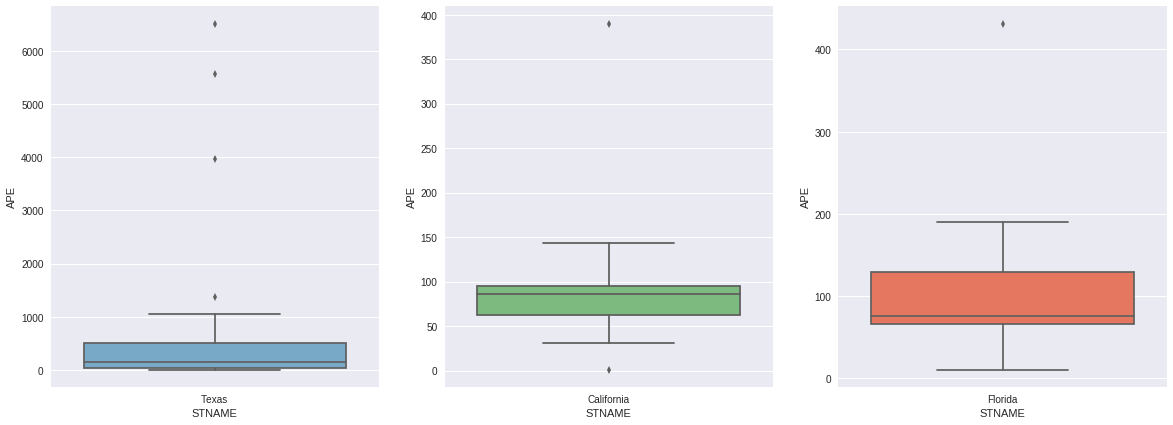

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,7))

sns.boxplot(x='STNAME', y="APE", data=STFilter[ STFilter['STNAME'] == 'Texas' ], ax=ax1, palette="Blues")
sns.boxplot(x='STNAME', y="APE", data=STFilter[ STFilter['STNAME'] == 'California' ], ax=ax2, palette="Greens")
sns.boxplot(x='STNAME', y="APE", data=STFilter[ STFilter['STNAME'] == 'Florida' ], ax=ax3, palette="Reds")